# Saber Pro Data Exploration

This notebook performs initial exploration of the Saber Pro dataset from 2018-2022.

In [1]:
# Cell 1: Import necessary libraries and define the processor class
import pandas as pd
import numpy as np
import sqlite3
from pathlib import Path
import logging
from tqdm import tqdm
import os

class SaberProProcessor:
    def __init__(self, file_path: str):
        self.file_path = file_path
        # Create directories if they don't exist
        os.makedirs('data/processed', exist_ok=True)
        self.setup_logging()
        
    def setup_logging(self):
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.StreamHandler()  # Just use console logging for now
            ]
        )
        self.logger = logging.getLogger(__name__)
        
    def create_database(self) -> Path:
        db_path = Path('data/processed/saber_pro.db')
        os.makedirs(db_path.parent, exist_ok=True)
        
        conn = sqlite3.connect(db_path)
        conn.execute("DROP TABLE IF EXISTS saber_pro")
        
        create_table_sql = """
        CREATE TABLE IF NOT EXISTS saber_pro (
            periodo TEXT,
            estu_consecutivo TEXT,
            estu_tipodocumento TEXT,
            estu_pais_reside TEXT,
            estu_cod_reside_depto TEXT,
            estu_depto_reside TEXT,
            estu_cod_reside_mcpio TEXT,
            estu_mcpio_reside TEXT,
            estu_coddane_cole_termino TEXT,
            estu_cod_cole_mcpio_termino TEXT,
            estu_cod_depto_presentacion TEXT,
            inst_cod_institucion TEXT,
            inst_nombre_institucion TEXT,
            inst_caracter_academico TEXT,
            estu_nucleo_pregrado TEXT,
            estu_inst_departamento TEXT,
            estu_inst_codmunicipio TEXT,
            estu_inst_municipio TEXT,
            estu_prgm_academico TEXT,
            estu_prgm_departamento TEXT,
            estu_prgm_codmunicipio TEXT,
            estu_prgm_municipio TEXT,
            estu_nivel_prgm_academico TEXT,
            estu_metodo_prgm TEXT,
            estu_valormatriculauniversidad TEXT,
            estu_depto_presentacion TEXT,
            estu_cod_mcpio_presentacion TEXT,
            estu_mcpio_presentacion TEXT,
            estu_pagomatriculabeca TEXT,
            estu_pagomatriculacredito TEXT,
            estu_horassemanatrabaja TEXT,
            estu_snies_prgmacademico TEXT,
            estu_privado_libertad TEXT,
            estu_nacionalidad TEXT,
            estu_estudiante TEXT,
            estu_genero TEXT,
            estu_cole_termino TEXT,
            estu_pagomatriculapadres TEXT,
            estu_estadoinvestigacion TEXT,
            estu_fechanacimiento TEXT,
            estu_pagomatriculapropio TEXT,
            estu_tipodocumentosb11 TEXT,
            fami_educacionpadre TEXT,
            fami_tieneautomovil TEXT,
            fami_tienelavadora TEXT,
            fami_estratovivienda TEXT,
            fami_tienecomputador TEXT,
            fami_tieneinternet TEXT,
            fami_educacionmadre TEXT,
            inst_origen TEXT,
            mod_razona_cuantitat_punt REAL,
            mod_comuni_escrita_punt REAL,
            mod_comuni_escrita_desem TEXT,
            mod_ingles_desem TEXT,
            mod_lectura_critica_punt REAL,
            mod_ingles_punt REAL,
            mod_competen_ciudada_punt REAL
        )
        """
        
        conn.execute(create_table_sql)
        conn.close()
        return db_path
    
    def process_data(self, chunk_size: int = 50000) -> None:
        db_path = self.create_database()
        conn = sqlite3.connect(db_path)
        
        total_rows = sum(1 for _ in open(self.file_path)) - 1
        total_chunks = (total_rows // chunk_size) + 1
        
        print(f"Starting data processing: {total_rows:,} total rows")
        
        chunks = pd.read_csv(self.file_path, chunksize=chunk_size)
        for i, chunk in enumerate(tqdm(chunks, total=total_chunks, desc="Processing chunks")):
            try:
                chunk.columns = chunk.columns.str.lower()
                chunk.to_sql('saber_pro', conn, if_exists='append', index=False)
                conn.commit()
            except Exception as e:
                print(f"Error processing chunk {i}: {str(e)}")
                conn.rollback()
                raise
        
        print("\nCreating indexes...")
        conn.execute("CREATE INDEX IF NOT EXISTS idx_periodo ON saber_pro(periodo)")
        conn.execute("CREATE INDEX IF NOT EXISTS idx_genero ON saber_pro(estu_genero)")
        conn.execute("CREATE INDEX IF NOT EXISTS idx_estrato ON saber_pro(fami_estratovivienda)")
        conn.execute("CREATE INDEX IF NOT EXISTS idx_inst_caracter ON saber_pro(inst_caracter_academico)")
        
        cursor = conn.cursor()
        cursor.execute("SELECT COUNT(*) FROM saber_pro")
        total_count = cursor.fetchone()[0]
        print(f"\nTotal records loaded: {total_count:,}")
        
        conn.close()

In [3]:
# Cell 2: Run the data processing
file_path = '/Users/manuelcastillo/Documents/Saber_pro_dataset/Resultados__nicos_Saber_Pro_20250201.csv'
processor = SaberProProcessor(file_path)
processor.process_data(chunk_size=50000)

NameError: name 'SaberProProcessor' is not defined

In [7]:
# Define query helper function
def query_db(query: str) -> pd.DataFrame:
    """Helper function to run SQL queries"""
    conn = sqlite3.connect('data/processed/saber_pro.db')
    result = pd.read_sql_query(query, conn)
    conn.close()
    return result

# Now run the queries
# Check ESTU_NIVEL_PRGM_ACADEMICO distribution
program_level = query_db("""
    SELECT 
        estu_nivel_prgm_academico,
        COUNT(*) as count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
    FROM saber_pro
    GROUP BY estu_nivel_prgm_academico
    ORDER BY count DESC;
""")

print("\nDistribution of Academic Program Levels:")
print(program_level)

# Check Mother's Education Level
mother_education = query_db("""
    SELECT 
        fami_educacionmadre,
        COUNT(*) as count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
    FROM saber_pro
    GROUP BY fami_educacionmadre
    ORDER BY count DESC;
""")

print("\nDistribution of Mother's Education Level:")
print(mother_education)

# Check Tuition Values with ranges
tuition_ranges = query_db("""
    WITH clean_tuition AS (
        SELECT 
            CAST(estu_valormatriculauniversidad AS INTEGER) as tuition
        FROM saber_pro
        WHERE estu_valormatriculauniversidad ~ '^[0-9]+$'
    )
    SELECT 
        CASE 
            WHEN tuition <= 1000000 THEN '0-1M'
            WHEN tuition <= 2000000 THEN '1M-2M'
            WHEN tuition <= 3000000 THEN '2M-3M'
            WHEN tuition <= 4000000 THEN '3M-4M'
            WHEN tuition <= 5000000 THEN '4M-5M'
            ELSE 'More than 5M'
        END as tuition_range,
        COUNT(*) as count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
    FROM clean_tuition
    GROUP BY tuition_range
    ORDER BY 
        CASE tuition_range
            WHEN '0-1M' THEN 1
            WHEN '1M-2M' THEN 2
            WHEN '2M-3M' THEN 3
            WHEN '3M-4M' THEN 4
            WHEN '4M-5M' THEN 5
            ELSE 6
        END;
""")

print("\nDistribution of Tuition Values (in COP):")
print(tuition_ranges)


Distribution of Academic Program Levels:
  estu_nivel_prgm_academico    count  percentage
0             UNIVERSITARIO  1217482       100.0

Distribution of Mother's Education Level:
                     fami_educacionmadre   count  percentage
0     Secundaria (Bachillerato) completa  250124       20.54
1                    Primaria incompleta  172886       14.20
2         Técnica o tecnológica completa  160854       13.21
3         Educación profesional completa  152001       12.48
4   Secundaria (Bachillerato) incompleta  139456       11.45
5                      Primaria completa   98295        8.07
6                              Postgrado   82756        6.80
7       Técnica o tecnológica incompleta   47694        3.92
8                                   None   42018        3.45
9       Educación profesional incompleta   38676        3.18
10                               Ninguno   24348        2.00
11                               No sabe    5250        0.43
12                      

DatabaseError: Execution failed on sql '
    WITH clean_tuition AS (
        SELECT 
            CAST(estu_valormatriculauniversidad AS INTEGER) as tuition
        FROM saber_pro
        WHERE estu_valormatriculauniversidad ~ '^[0-9]+$'
    )
    SELECT 
        CASE 
            WHEN tuition <= 1000000 THEN '0-1M'
            WHEN tuition <= 2000000 THEN '1M-2M'
            WHEN tuition <= 3000000 THEN '2M-3M'
            WHEN tuition <= 4000000 THEN '3M-4M'
            WHEN tuition <= 5000000 THEN '4M-5M'
            ELSE 'More than 5M'
        END as tuition_range,
        COUNT(*) as count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
    FROM clean_tuition
    GROUP BY tuition_range
    ORDER BY 
        CASE tuition_range
            WHEN '0-1M' THEN 1
            WHEN '1M-2M' THEN 2
            WHEN '2M-3M' THEN 3
            WHEN '3M-4M' THEN 4
            WHEN '4M-5M' THEN 5
            ELSE 6
        END;
': near "~": syntax error


Distribution of Tuition Values:
                              tuition_range   count  percentage
0                               Matrícula 0   51063        4.24
1                          Menos de 500 mil  138782       11.51
2         Entre 500 mil y menos de 1 millón  129353       10.73
3    Entre 1 millón y menos de 2.5 millones  350406       29.07
4  Entre 2.5 millones y menos de 4 millones  220554       18.30
5  Entre 4 millones y menos de 5.5 millones  124018       10.29
6  Entre 5.5 millones y menos de 7 millones   68205        5.66
7                         Más de 7 millones  123036       10.21


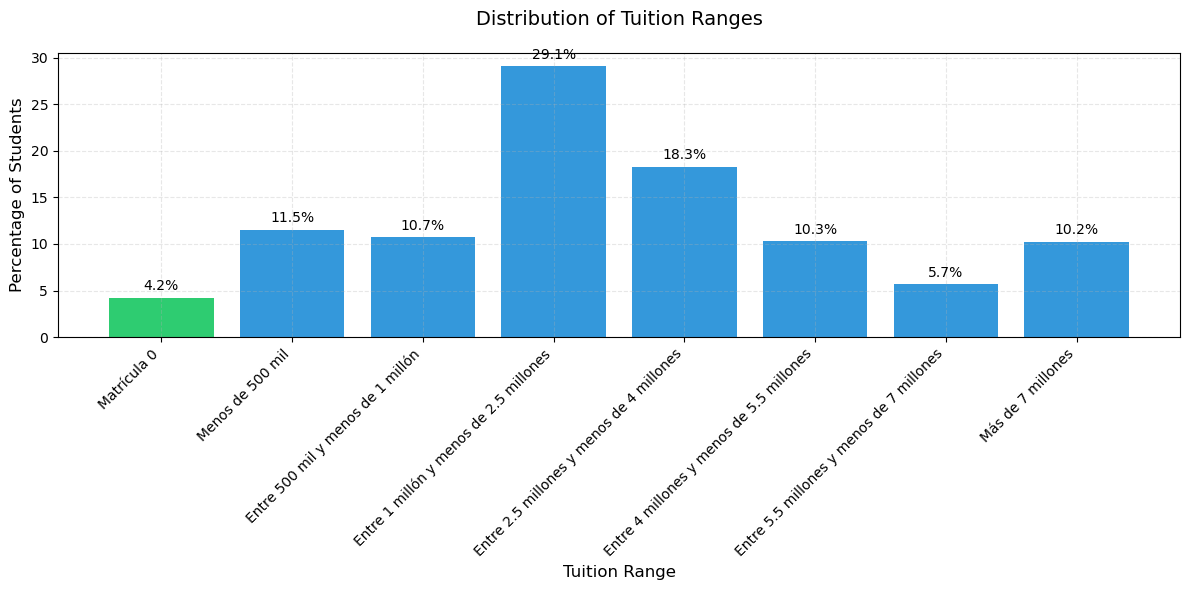


Average Performance by Tuition Range:
                              tuition_range  avg_score  student_count
0                               Matrícula 0     148.28          51063
1                          Menos de 500 mil     150.94         138782
2         Entre 500 mil y menos de 1 millón     145.58         129353
3    Entre 1 millón y menos de 2.5 millones     139.48         350406
4  Entre 2.5 millones y menos de 4 millones     144.41         220554
5  Entre 4 millones y menos de 5.5 millones     152.57         124018
6  Entre 5.5 millones y menos de 7 millones     158.43          68205
7                         Más de 7 millones     173.13         123036


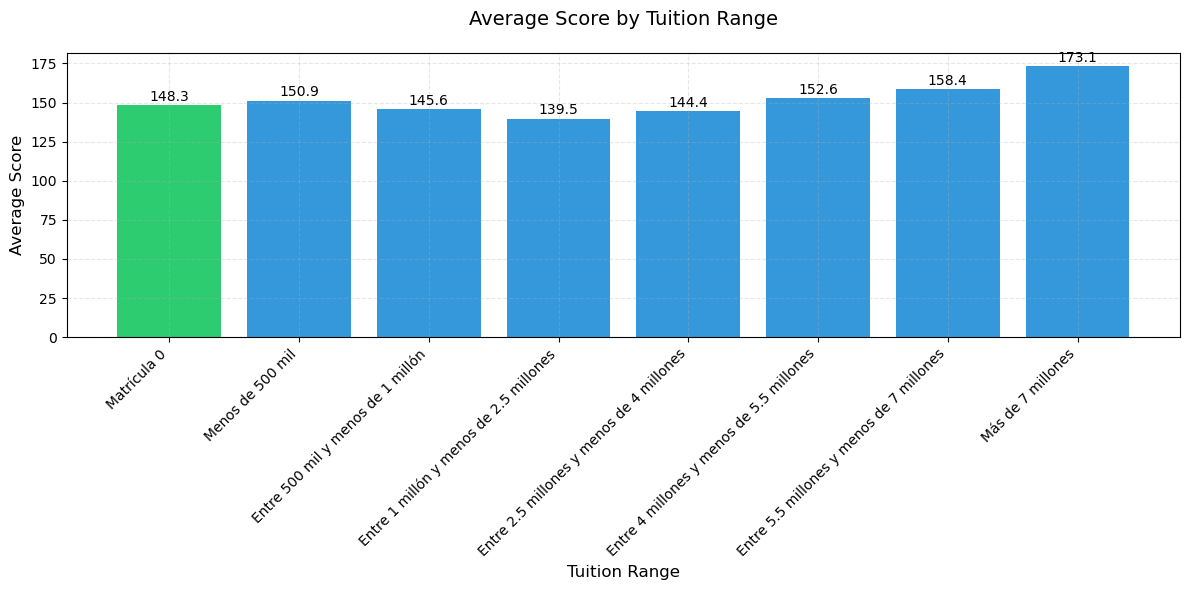

In [21]:
# Import required libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

# Analyze tuition ranges with proper ordering and "No pagó matrícula" as 0
tuition_ranges = query_db("""
    SELECT 
        CASE 
            WHEN estu_valormatriculauniversidad = 'No pagó matrícula' THEN 'Matrícula 0'
            ELSE estu_valormatriculauniversidad 
        END as tuition_range,
        COUNT(*) as count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
    FROM saber_pro
    WHERE estu_valormatriculauniversidad IS NOT NULL
    GROUP BY 
        CASE 
            WHEN estu_valormatriculauniversidad = 'No pagó matrícula' THEN 'Matrícula 0'
            ELSE estu_valormatriculauniversidad 
        END
    ORDER BY 
        CASE tuition_range
            WHEN 'Matrícula 0' THEN 0
            WHEN 'Menos de 500 mil' THEN 1
            WHEN 'Entre 500 mil y menos de 1 millón' THEN 2
            WHEN 'Entre 1 millón y menos de 2.5 millones' THEN 3
            WHEN 'Entre 2.5 millones y menos de 4 millones' THEN 4
            WHEN 'Entre 4 millones y menos de 5.5 millones' THEN 5
            WHEN 'Entre 5.5 millones y menos de 7 millones' THEN 6
            WHEN 'Más de 7 millones' THEN 7
            ELSE 8
        END;
""")

print("\nDistribution of Tuition Values:")
print(tuition_ranges)

# Create visualization
plt.figure(figsize=(12, 6))
colors = ['#2ecc71' if x == 'Matrícula 0' else '#3498db' for x in tuition_ranges['tuition_range']]
bars = plt.bar(range(len(tuition_ranges)), tuition_ranges['percentage'], color=colors)
plt.xticks(range(len(tuition_ranges)), tuition_ranges['tuition_range'], rotation=45, ha='right')
plt.title('Distribution of Tuition Ranges', pad=20, fontsize=14)
plt.xlabel('Tuition Range', fontsize=12)
plt.ylabel('Percentage of Students', fontsize=12)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%',
             ha='center', va='bottom')

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Performance analysis by tuition range
performance_by_tuition = query_db("""
    SELECT 
        CASE 
            WHEN estu_valormatriculauniversidad = 'No pagó matrícula' THEN 'Matrícula 0'
            ELSE estu_valormatriculauniversidad 
        END as tuition_range,
        ROUND(AVG((mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
                   mod_ingles_punt + mod_competen_ciudada_punt)/4.0), 2) as avg_score,
        COUNT(*) as student_count
    FROM saber_pro
    WHERE estu_valormatriculauniversidad IS NOT NULL
    GROUP BY 
        CASE 
            WHEN estu_valormatriculauniversidad = 'No pagó matrícula' THEN 'Matrícula 0'
            ELSE estu_valormatriculauniversidad 
        END
    ORDER BY 
        CASE tuition_range
            WHEN 'Matrícula 0' THEN 0
            WHEN 'Menos de 500 mil' THEN 1
            WHEN 'Entre 500 mil y menos de 1 millón' THEN 2
            WHEN 'Entre 1 millón y menos de 2.5 millones' THEN 3
            WHEN 'Entre 2.5 millones y menos de 4 millones' THEN 4
            WHEN 'Entre 4 millones y menos de 5.5 millones' THEN 5
            WHEN 'Entre 5.5 millones y menos de 7 millones' THEN 6
            WHEN 'Más de 7 millones' THEN 7
            ELSE 8
        END;
""")

print("\nAverage Performance by Tuition Range:")
print(performance_by_tuition)

# Visualize performance by tuition
plt.figure(figsize=(12, 6))
colors = ['#2ecc71' if x == 'Matrícula 0' else '#3498db' for x in performance_by_tuition['tuition_range']]
bars = plt.bar(range(len(performance_by_tuition)), performance_by_tuition['avg_score'], color=colors)
plt.xticks(range(len(performance_by_tuition)), performance_by_tuition['tuition_range'], rotation=45, ha='right')
plt.title('Average Score by Tuition Range', pad=20, fontsize=14)
plt.xlabel('Tuition Range', fontsize=12)
plt.ylabel('Average Score', fontsize=12)

# Add score labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}',
             ha='center', va='bottom')

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Current parent education categories:
                         father_education  \
0                     Primaria incompleta   
1      Secundaria (Bachillerato) completa   
2          Educación profesional completa   
3    Secundaria (Bachillerato) incompleta   
4          Técnica o tecnológica completa   
..                                    ...   
164                                  None   
165                               No sabe   
166                             No Aplica   
167                                  None   
168                                  None   

                         mother_education   count  
0                     Primaria incompleta  102661  
1      Secundaria (Bachillerato) completa   94636  
2          Educación profesional completa   58673  
3    Secundaria (Bachillerato) incompleta   39730  
4          Técnica o tecnológica completa   39289  
..                                    ...     ...  
164                             Postgrado      87  
165   

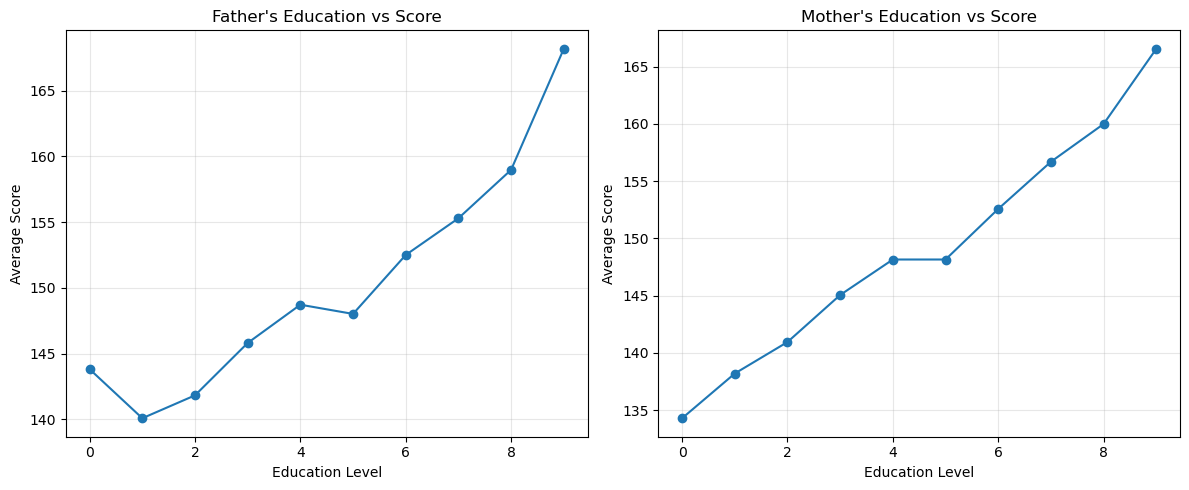


Education Level Categories:
0: No education/Unknown
1: Incomplete Primary
2: Complete Primary
3: Incomplete Secondary
4: Complete Secondary
5: Incomplete Technical
6: Complete Technical
7: Incomplete Professional
8: Complete Professional
9: Postgraduate


In [23]:
# Check current categories for parents' education
parent_education = query_db("""
    SELECT 
        fami_educacionpadre as father_education,
        fami_educacionmadre as mother_education,
        COUNT(*) as count
    FROM saber_pro
    GROUP BY father_education, mother_education
    ORDER BY count DESC;
""")

print("Current parent education categories:")
print(parent_education)

# Now let's create an ordered categorization
education_levels = query_db("""
    WITH parent_education AS (
        SELECT 
            estu_consecutivo,
            CASE 
                WHEN fami_educacionpadre IN ('Ninguno', 'No sabe', 'No Aplica') THEN 0
                WHEN fami_educacionpadre = 'Primaria incompleta' THEN 1
                WHEN fami_educacionpadre = 'Primaria completa' THEN 2
                WHEN fami_educacionpadre = 'Secundaria (Bachillerato) incompleta' THEN 3
                WHEN fami_educacionpadre = 'Secundaria (Bachillerato) completa' THEN 4
                WHEN fami_educacionpadre = 'Técnica o tecnológica incompleta' THEN 5
                WHEN fami_educacionpadre = 'Técnica o tecnológica completa' THEN 6
                WHEN fami_educacionpadre = 'Educación profesional incompleta' THEN 7
                WHEN fami_educacionpadre = 'Educación profesional completa' THEN 8
                WHEN fami_educacionpadre = 'Postgrado' THEN 9
            END as father_education_level,
            CASE 
                WHEN fami_educacionmadre IN ('Ninguno', 'No sabe', 'No Aplica') THEN 0
                WHEN fami_educacionmadre = 'Primaria incompleta' THEN 1
                WHEN fami_educacionmadre = 'Primaria completa' THEN 2
                WHEN fami_educacionmadre = 'Secundaria (Bachillerato) incompleta' THEN 3
                WHEN fami_educacionmadre = 'Secundaria (Bachillerato) completa' THEN 4
                WHEN fami_educacionmadre = 'Técnica o tecnológica incompleta' THEN 5
                WHEN fami_educacionmadre = 'Técnica o tecnológica completa' THEN 6
                WHEN fami_educacionmadre = 'Educación profesional incompleta' THEN 7
                WHEN fami_educacionmadre = 'Educación profesional completa' THEN 8
                WHEN fami_educacionmadre = 'Postgrado' THEN 9
            END as mother_education_level,
            (mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
             mod_ingles_punt + mod_competen_ciudada_punt)/4.0 as avg_score
        FROM saber_pro
        WHERE fami_educacionpadre IS NOT NULL 
        AND fami_educacionmadre IS NOT NULL
    )
    SELECT 
        father_education_level,
        mother_education_level,
        ROUND(AVG(avg_score), 2) as avg_score,
        COUNT(*) as student_count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage
    FROM parent_education
    GROUP BY father_education_level, mother_education_level
    ORDER BY father_education_level, mother_education_level;
""")

print("\nEducation levels analysis:")
print(education_levels)

# Visualize the relationship between parents' education and scores
plt.figure(figsize=(12, 5))

# Plot 1: Average score by father's education
plt.subplot(1, 2, 1)
father_scores = query_db("""
    WITH parent_education AS (
        SELECT 
            CASE 
                WHEN fami_educacionpadre IN ('Ninguno', 'No sabe', 'No Aplica') THEN 0
                WHEN fami_educacionpadre = 'Primaria incompleta' THEN 1
                WHEN fami_educacionpadre = 'Primaria completa' THEN 2
                WHEN fami_educacionpadre = 'Secundaria (Bachillerato) incompleta' THEN 3
                WHEN fami_educacionpadre = 'Secundaria (Bachillerato) completa' THEN 4
                WHEN fami_educacionpadre = 'Técnica o tecnológica incompleta' THEN 5
                WHEN fami_educacionpadre = 'Técnica o tecnológica completa' THEN 6
                WHEN fami_educacionpadre = 'Educación profesional incompleta' THEN 7
                WHEN fami_educacionpadre = 'Educación profesional completa' THEN 8
                WHEN fami_educacionpadre = 'Postgrado' THEN 9
            END as education_level,
            (mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
             mod_ingles_punt + mod_competen_ciudada_punt)/4.0 as avg_score
        FROM saber_pro
        WHERE fami_educacionpadre IS NOT NULL
    )
    SELECT 
        education_level,
        ROUND(AVG(avg_score), 2) as avg_score
    FROM parent_education
    GROUP BY education_level
    ORDER BY education_level;
""")

plt.plot(father_scores['education_level'], father_scores['avg_score'], 'o-')
plt.title("Father's Education vs Score")
plt.xlabel('Education Level')
plt.ylabel('Average Score')
plt.grid(True, alpha=0.3)

# Plot 2: Average score by mother's education
plt.subplot(1, 2, 2)
mother_scores = query_db("""
    WITH parent_education AS (
        SELECT 
            CASE 
                WHEN fami_educacionmadre IN ('Ninguno', 'No sabe', 'No Aplica') THEN 0
                WHEN fami_educacionmadre = 'Primaria incompleta' THEN 1
                WHEN fami_educacionmadre = 'Primaria completa' THEN 2
                WHEN fami_educacionmadre = 'Secundaria (Bachillerato) incompleta' THEN 3
                WHEN fami_educacionmadre = 'Secundaria (Bachillerato) completa' THEN 4
                WHEN fami_educacionmadre = 'Técnica o tecnológica incompleta' THEN 5
                WHEN fami_educacionmadre = 'Técnica o tecnológica completa' THEN 6
                WHEN fami_educacionmadre = 'Educación profesional incompleta' THEN 7
                WHEN fami_educacionmadre = 'Educación profesional completa' THEN 8
                WHEN fami_educacionmadre = 'Postgrado' THEN 9
            END as education_level,
            (mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
             mod_ingles_punt + mod_competen_ciudada_punt)/4.0 as avg_score
        FROM saber_pro
        WHERE fami_educacionmadre IS NOT NULL
    )
    SELECT 
        education_level,
        ROUND(AVG(avg_score), 2) as avg_score
    FROM parent_education
    GROUP BY education_level
    ORDER BY education_level;
""")

plt.plot(mother_scores['education_level'], mother_scores['avg_score'], 'o-')
plt.title("Mother's Education vs Score")
plt.xlabel('Education Level')
plt.ylabel('Average Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nEducation Level Categories:")
print("0: No education/Unknown")
print("1: Incomplete Primary")
print("2: Complete Primary")
print("3: Incomplete Secondary")
print("4: Complete Secondary")
print("5: Incomplete Technical")
print("6: Complete Technical")
print("7: Incomplete Professional")
print("8: Complete Professional")
print("9: Postgraduate")


Distribution of Institution Types (Grouped):
  institution_type   count  percentage  avg_score
0          Private  810967       66.61     147.81
1           Public  406515       33.39     150.33


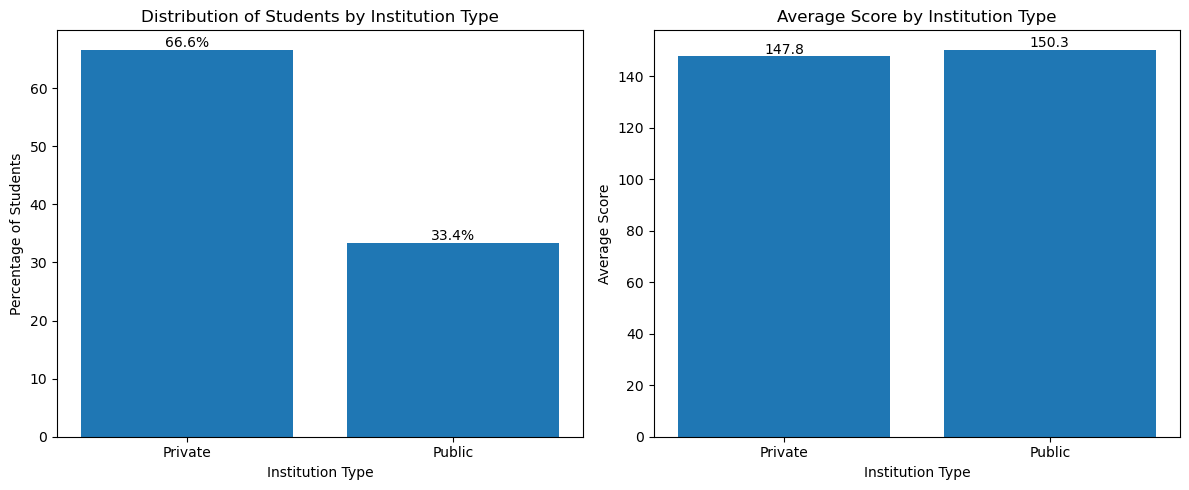

In [27]:
# Group institutions into Public and Private
institution_types_grouped = query_db("""
    SELECT 
        CASE 
            WHEN inst_origen LIKE 'OFICIAL%' OR inst_origen = 'REGIMEN ESPECIAL' THEN 'Public'
            WHEN inst_origen LIKE 'NO OFICIAL%' THEN 'Private'
        END as institution_type,
        COUNT(*) as count,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage,
        ROUND(AVG((mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
                   mod_ingles_punt + mod_competen_ciudada_punt)/4.0), 2) as avg_score
    FROM saber_pro
    WHERE inst_origen IS NOT NULL
    GROUP BY 
        CASE 
            WHEN inst_origen LIKE 'OFICIAL%' OR inst_origen = 'REGIMEN ESPECIAL' THEN 'Public'
            WHEN inst_origen LIKE 'NO OFICIAL%' THEN 'Private'
        END
    ORDER BY institution_type;
""")

print("\nDistribution of Institution Types (Grouped):")
print(institution_types_grouped)

# Visualize the grouped distribution and performance
plt.figure(figsize=(12, 5))

# Plot 1: Distribution
plt.subplot(1, 2, 1)
plt.bar(institution_types_grouped['institution_type'], institution_types_grouped['percentage'])
plt.title('Distribution of Students by Institution Type')
plt.xlabel('Institution Type')
plt.ylabel('Percentage of Students')
for i, v in enumerate(institution_types_grouped['percentage']):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center')

# Plot 2: Performance
plt.subplot(1, 2, 2)
plt.bar(institution_types_grouped['institution_type'], institution_types_grouped['avg_score'])
plt.title('Average Score by Institution Type')
plt.xlabel('Institution Type')
plt.ylabel('Average Score')
for i, v in enumerate(institution_types_grouped['avg_score']):
    plt.text(i, v + 1, f'{v:.1f}', ha='center')

plt.tight_layout()
plt.show()


Performance by Institution Type and Estrato:
   institution_type  estrato  student_count  avg_score
0           Private        1         102829     136.35
1            Public        1         103046     140.44
2           Private        2         259655     143.02
3            Public        2         150167     150.34
4           Private        3         264432     149.53
5            Public        3         101622     157.98
6           Private        4          90296     160.40
7            Public        4          22277     166.86
8           Private        5          35339     167.12
9            Public        5           5334     167.46
10          Private        6          20059     172.82
11           Public        6           1650     161.85


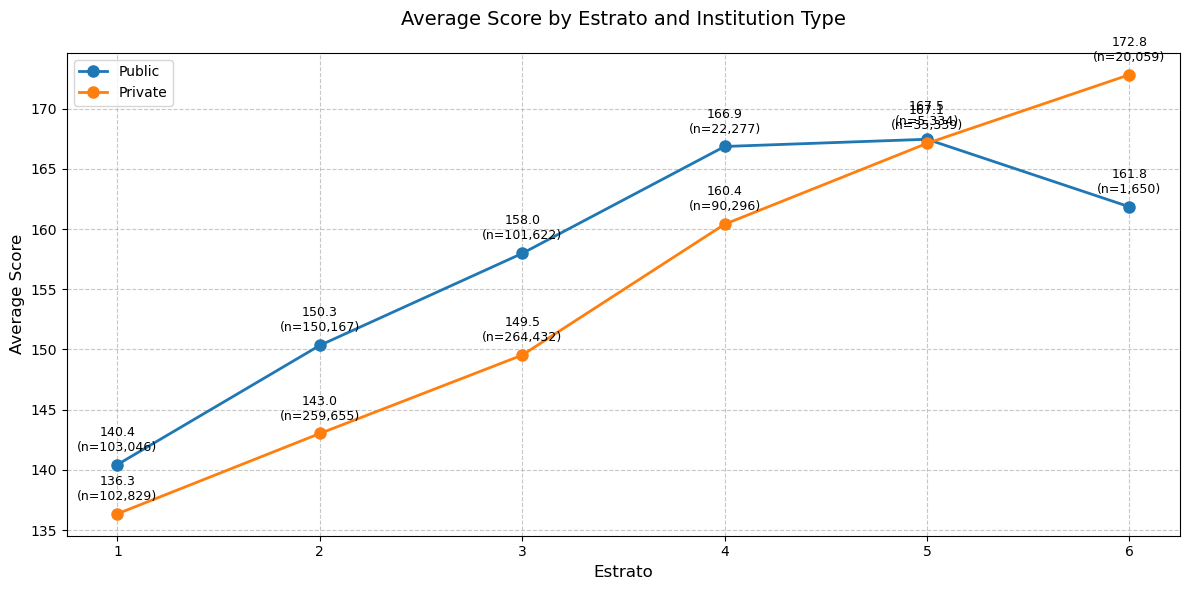


Gap Analysis (Private - Public) by Estrato:
Estrato 1:
  Private: 136.35 (n=102,829)
  Public:  140.44 (n=103,046)
  Gap:     -4.09 points (-2.9%)
  Distribution: Private 49.9% / Public 50.1%

Estrato 2:
  Private: 143.02 (n=259,655)
  Public:  150.34 (n=150,167)
  Gap:     -7.32 points (-4.9%)
  Distribution: Private 63.4% / Public 36.6%

Estrato 3:
  Private: 149.53 (n=264,432)
  Public:  157.98 (n=101,622)
  Gap:     -8.45 points (-5.3%)
  Distribution: Private 72.2% / Public 27.8%

Estrato 4:
  Private: 160.40 (n=90,296)
  Public:  166.86 (n=22,277)
  Gap:     -6.46 points (-3.9%)
  Distribution: Private 80.2% / Public 19.8%

Estrato 5:
  Private: 167.12 (n=35,339)
  Public:  167.46 (n=5,334)
  Gap:     -0.34 points (-0.2%)
  Distribution: Private 86.9% / Public 13.1%

Estrato 6:
  Private: 172.82 (n=20,059)
  Public:  161.85 (n=1,650)
  Gap:     +10.97 points (+6.8%)
  Distribution: Private 92.4% / Public 7.6%



/var/folders/sf/chx88sh91jz6pxty2rvf48x40000gn/T/ipykernel_68667/3331940837.py:70: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  private_score = float(private_data['avg_score'])
/var/folders/sf/chx88sh91jz6pxty2rvf48x40000gn/T/ipykernel_68667/3331940837.py:71: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  public_score = float(public_data['avg_score'])
/var/folders/sf/chx88sh91jz6pxty2rvf48x40000gn/T/ipykernel_68667/3331940837.py:72: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  private_count = int(private_data['student_count'])
/var/folders/sf/chx88sh91jz6pxty2rvf48x40000gn/T/ipykernel_68667/3331940837.py:73: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeE

In [31]:
# Analyze performance by institution type and estrato
performance_by_type_estrato = query_db("""
    SELECT 
        CASE 
            WHEN inst_origen LIKE 'OFICIAL%' OR inst_origen = 'REGIMEN ESPECIAL' THEN 'Public'
            WHEN inst_origen LIKE 'NO OFICIAL%' THEN 'Private'
        END as institution_type,
        CAST(REPLACE(fami_estratovivienda, 'Estrato ', '') AS INTEGER) as estrato,
        COUNT(*) as student_count,
        ROUND(AVG((mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
                   mod_ingles_punt + mod_competen_ciudada_punt)/4.0), 2) as avg_score
    FROM saber_pro
    WHERE inst_origen IS NOT NULL
        AND fami_estratovivienda LIKE 'Estrato %'
    GROUP BY 
        CASE 
            WHEN inst_origen LIKE 'OFICIAL%' OR inst_origen = 'REGIMEN ESPECIAL' THEN 'Public'
            WHEN inst_origen LIKE 'NO OFICIAL%' THEN 'Private'
        END,
        CAST(REPLACE(fami_estratovivienda, 'Estrato ', '') AS INTEGER)
    ORDER BY estrato, institution_type;
""")

print("\nPerformance by Institution Type and Estrato:")
print(performance_by_type_estrato)

# Create visualization
plt.figure(figsize=(12, 6))

# Plot lines for each institution type
for inst_type in ['Public', 'Private']:
    data = performance_by_type_estrato[performance_by_type_estrato['institution_type'] == inst_type]
    plt.plot(data['estrato'], data['avg_score'], 'o-', 
            label=inst_type, linewidth=2, markersize=8)

plt.title('Average Score by Estrato and Institution Type', pad=20, fontsize=14)
plt.xlabel('Estrato', fontsize=12)
plt.ylabel('Average Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Add value labels
for inst_type in ['Public', 'Private']:
    data = performance_by_type_estrato[performance_by_type_estrato['institution_type'] == inst_type]
    for idx, row in data.iterrows():
        plt.annotate(f'{row["avg_score"]:.1f}\n(n={row["student_count"]:,})', 
                    (row['estrato'], row['avg_score']),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center',
                    fontsize=9)

plt.tight_layout()
plt.show()

# Calculate gap between public and private by estrato
print("\nGap Analysis (Private - Public) by Estrato:")
for estrato in range(1, 7):
    private_data = performance_by_type_estrato[
        (performance_by_type_estrato['institution_type'] == 'Private') & 
        (performance_by_type_estrato['estrato'] == estrato)
    ]
    
    public_data = performance_by_type_estrato[
        (performance_by_type_estrato['institution_type'] == 'Public') & 
        (performance_by_type_estrato['estrato'] == estrato)
    ]
    
    if not private_data.empty and not public_data.empty:
        private_score = float(private_data['avg_score'])
        public_score = float(public_data['avg_score'])
        private_count = int(private_data['student_count'])
        public_count = int(public_data['student_count'])
        
        gap = private_score - public_score
        print(f"Estrato {estrato}:")
        print(f"  Private: {private_score:.2f} (n={private_count:,})")
        print(f"  Public:  {public_score:.2f} (n={public_count:,})")
        print(f"  Gap:     {gap:+.2f} points ({(gap/public_score)*100:+.1f}%)")
        print(f"  Distribution: Private {private_count/(private_count+public_count)*100:.1f}% / Public {public_count/(private_count+public_count)*100:.1f}%")
        print()

Top 10 Universities by Average Score:
                                          university institution_type  \
0               UNIVERSIDAD DE LOS ANDES-BOGOTÁ D.C.          Private   
1       UNIVERSIDAD NACIONAL DE COLOMBIA-BOGOTÁ D.C.           Public   
2                           UNIVERSIDAD EIA-MEDELLIN          Private   
3  COLEGIO DE ESTUDIOS SUPERIORES DE ADMINISTRACI...          Private   
4          UNIVERSIDAD NACIONAL DE COLOMBIA-MEDELLIN           Public   
5                      UNIVERSIDAD DE LA SABANA-CHIA          Private   
6                             UNIVERSIDAD ICESI-CALI          Private   
7  COLEGIO MAYOR DE NUESTRA SEÑORA DEL ROSARIO-BO...          Private   
8       PONTIFICIA UNIVERSIDAD JAVERIANA-BOGOTÁ D.C.          Private   
9                 UNIVERSIDAD DEL NORTE-BARRANQUILLA          Private   

   student_count  avg_score  
0          13389     193.52  
1          15336     188.57  
2           1418     188.12  
3           1052     187.15  
4       

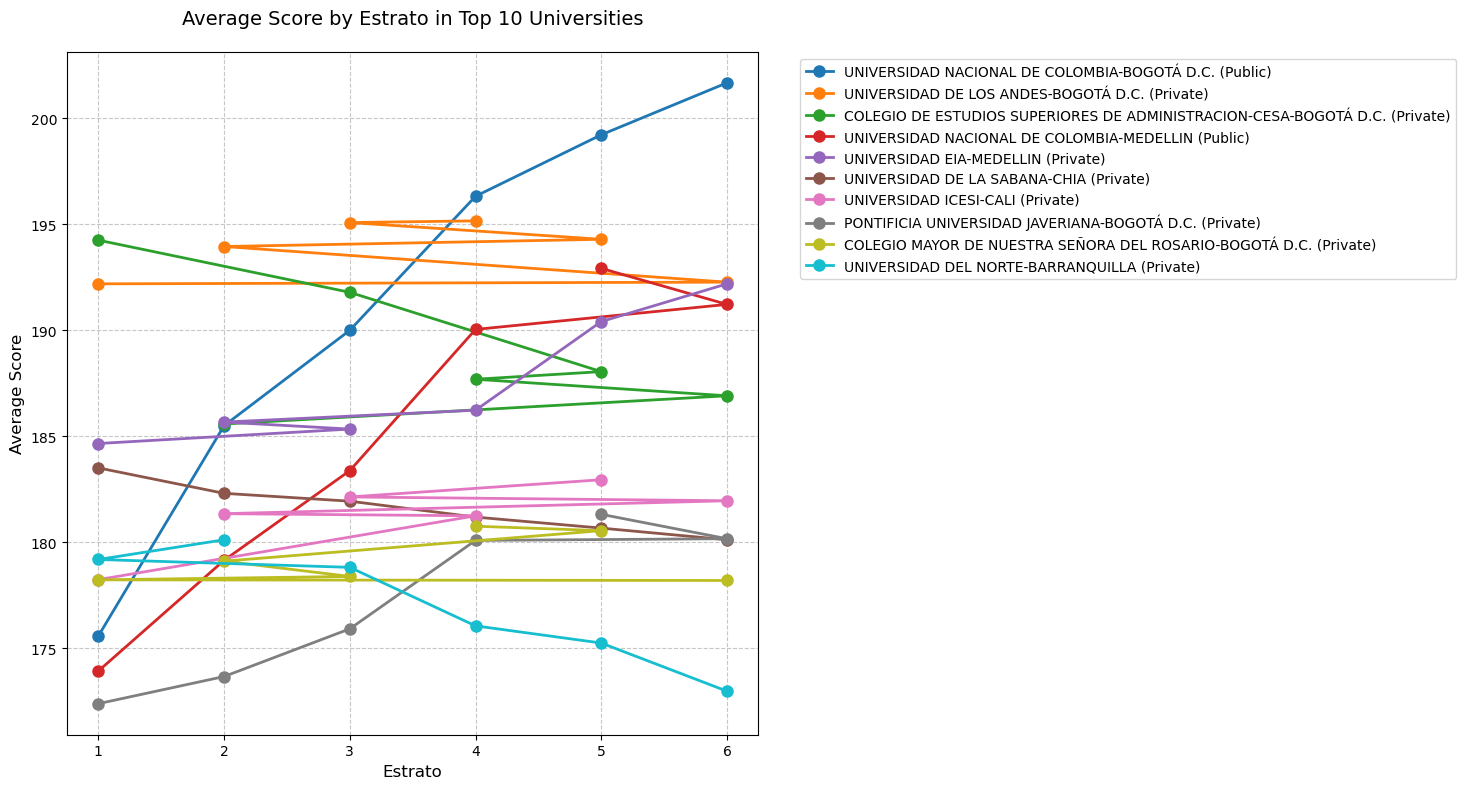


Summary Statistics for Top Universities:
                                          university institution_type  \
0               UNIVERSIDAD DE LOS ANDES-BOGOTÁ D.C.          Private   
1       UNIVERSIDAD NACIONAL DE COLOMBIA-BOGOTÁ D.C.           Public   
2                           UNIVERSIDAD EIA-MEDELLIN          Private   
3  COLEGIO DE ESTUDIOS SUPERIORES DE ADMINISTRACI...          Private   
4          UNIVERSIDAD NACIONAL DE COLOMBIA-MEDELLIN           Public   
5                             UNIVERSIDAD ICESI-CALI          Private   
6                      UNIVERSIDAD DE LA SABANA-CHIA          Private   
7  COLEGIO MAYOR DE NUESTRA SEÑORA DEL ROSARIO-BO...          Private   
8       PONTIFICIA UNIVERSIDAD JAVERIANA-BOGOTÁ D.C.          Private   
9                 UNIVERSIDAD DEL NORTE-BARRANQUILLA          Private   

   total_students  overall_avg_score  low_estrato_avg  high_estrato_avg  
0           12938             194.13           194.57            193.97  
1     

In [33]:
# First identify top 10 universities
top_universities = query_db("""
    SELECT 
        inst_nombre_institucion as university,
        CASE 
            WHEN inst_origen LIKE 'OFICIAL%' OR inst_origen = 'REGIMEN ESPECIAL' THEN 'Public'
            WHEN inst_origen LIKE 'NO OFICIAL%' THEN 'Private'
        END as institution_type,
        COUNT(*) as student_count,
        ROUND(AVG((mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
                   mod_ingles_punt + mod_competen_ciudada_punt)/4.0), 2) as avg_score
    FROM saber_pro
    WHERE inst_nombre_institucion IS NOT NULL
    GROUP BY inst_nombre_institucion, inst_origen
    HAVING student_count >= 1000  -- Minimum sample size for reliability
    ORDER BY avg_score DESC
    LIMIT 10;
""")

print("Top 10 Universities by Average Score:")
print(top_universities)

# Now analyze these universities by estrato
top_unis_by_estrato = query_db("""
    WITH top_unis AS (
        SELECT DISTINCT inst_nombre_institucion
        FROM (
            SELECT 
                inst_nombre_institucion,
                COUNT(*) as student_count,
                AVG((mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
                     mod_ingles_punt + mod_competen_ciudada_punt)/4.0) as avg_score
            FROM saber_pro
            GROUP BY inst_nombre_institucion
            HAVING student_count >= 1000
            ORDER BY avg_score DESC
            LIMIT 10
        )
    )
    SELECT 
        s.inst_nombre_institucion as university,
        CASE 
            WHEN s.inst_origen LIKE 'OFICIAL%' OR s.inst_origen = 'REGIMEN ESPECIAL' THEN 'Public'
            WHEN s.inst_origen LIKE 'NO OFICIAL%' THEN 'Private'
        END as institution_type,
        CAST(REPLACE(s.fami_estratovivienda, 'Estrato ', '') AS INTEGER) as estrato,
        COUNT(*) as student_count,
        ROUND(AVG((mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
                   mod_ingles_punt + mod_competen_ciudada_punt)/4.0), 2) as avg_score
    FROM saber_pro s
    INNER JOIN top_unis t ON s.inst_nombre_institucion = t.inst_nombre_institucion
    WHERE s.fami_estratovivienda LIKE 'Estrato %'
    GROUP BY s.inst_nombre_institucion, 
             CASE 
                WHEN s.inst_origen LIKE 'OFICIAL%' OR s.inst_origen = 'REGIMEN ESPECIAL' THEN 'Public'
                WHEN s.inst_origen LIKE 'NO OFICIAL%' THEN 'Private'
             END,
             CAST(REPLACE(s.fami_estratovivienda, 'Estrato ', '') AS INTEGER)
    ORDER BY avg_score DESC, estrato;
""")

print("\nPerformance of Top Universities by Estrato:")
print(top_unis_by_estrato)

# Create visualization
plt.figure(figsize=(15, 8))

# Create a color map for universities
universities = top_unis_by_estrato['university'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(universities)))
university_colors = dict(zip(universities, colors))

# Plot lines for each university
for univ in universities:
    data = top_unis_by_estrato[top_unis_by_estrato['university'] == univ]
    plt.plot(data['estrato'], data['avg_score'], 'o-', 
            label=f"{univ} ({data.iloc[0]['institution_type']})",
            linewidth=2, markersize=8)

plt.title('Average Score by Estrato in Top 10 Universities', pad=20, fontsize=14)
plt.xlabel('Estrato', fontsize=12)
plt.ylabel('Average Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Calculate summary statistics
print("\nSummary Statistics for Top Universities:")
summary_stats = query_db("""
    WITH top_unis AS (
        SELECT DISTINCT inst_nombre_institucion
        FROM (
            SELECT 
                inst_nombre_institucion,
                COUNT(*) as student_count,
                AVG((mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
                     mod_ingles_punt + mod_competen_ciudada_punt)/4.0) as avg_score
            FROM saber_pro
            GROUP BY inst_nombre_institucion
            HAVING student_count >= 1000
            ORDER BY avg_score DESC
            LIMIT 10
        )
    )
    SELECT 
        s.inst_nombre_institucion as university,
        CASE 
            WHEN s.inst_origen LIKE 'OFICIAL%' OR s.inst_origen = 'REGIMEN ESPECIAL' THEN 'Public'
            WHEN s.inst_origen LIKE 'NO OFICIAL%' THEN 'Private'
        END as institution_type,
        COUNT(*) as total_students,
        ROUND(AVG((mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
                   mod_ingles_punt + mod_competen_ciudada_punt)/4.0), 2) as overall_avg_score,
        ROUND(AVG(CASE WHEN CAST(REPLACE(s.fami_estratovivienda, 'Estrato ', '') AS INTEGER) <= 3 
                  THEN (mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
                        mod_ingles_punt + mod_competen_ciudada_punt)/4.0 END), 2) as low_estrato_avg,
        ROUND(AVG(CASE WHEN CAST(REPLACE(s.fami_estratovivienda, 'Estrato ', '') AS INTEGER) >= 4 
                  THEN (mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
                        mod_ingles_punt + mod_competen_ciudada_punt)/4.0 END), 2) as high_estrato_avg
    FROM saber_pro s
    INNER JOIN top_unis t ON s.inst_nombre_institucion = t.inst_nombre_institucion
    WHERE s.fami_estratovivienda LIKE 'Estrato %'
    GROUP BY s.inst_nombre_institucion, 
             CASE 
                WHEN s.inst_origen LIKE 'OFICIAL%' OR s.inst_origen = 'REGIMEN ESPECIAL' THEN 'Public'
                WHEN s.inst_origen LIKE 'NO OFICIAL%' THEN 'Private'
             END
    ORDER BY overall_avg_score DESC;
""")

print(summary_stats)

In [39]:
# Step 1: Create and analyze university deciles
decile_stats = query_db("""
    WITH university_scores AS (
        SELECT 
            inst_nombre_institucion,
            COUNT(*) as student_count,
            AVG((mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
                 mod_ingles_punt + mod_competen_ciudada_punt)/4.0) as avg_score
        FROM saber_pro
        GROUP BY inst_nombre_institucion
        HAVING student_count >= 100
    ),
    university_deciles AS (
        SELECT 
            inst_nombre_institucion,
            avg_score,
            NTILE(10) OVER (ORDER BY avg_score) as decile
        FROM university_scores
    )
    SELECT 
        decile,
        COUNT(DISTINCT inst_nombre_institucion) as n_universities,
        ROUND(MIN(avg_score), 2) as min_score,
        ROUND(MAX(avg_score), 2) as max_score,
        ROUND(AVG(avg_score), 2) as avg_score
    FROM university_deciles
    GROUP BY decile
    ORDER BY decile;
""")

print("University Decile Statistics:")
print(decile_stats)

# Step 2: Create and analyze department quartiles
department_stats = query_db("""
    WITH department_scores AS (
        SELECT 
            estu_inst_departamento as department,
            COUNT(*) as student_count,
            AVG((mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
                 mod_ingles_punt + mod_competen_ciudada_punt)/4.0) as avg_score
        FROM saber_pro
        WHERE estu_inst_departamento IS NOT NULL
        GROUP BY estu_inst_departamento
    ),
    department_quartiles AS (
        SELECT 
            department,
            avg_score,
            NTILE(4) OVER (ORDER BY avg_score) as quartile
        FROM department_scores
    )
    SELECT 
        quartile,
        COUNT(DISTINCT department) as n_departments,
        ROUND(MIN(avg_score), 2) as min_score,
        ROUND(MAX(avg_score), 2) as max_score,
        ROUND(AVG(avg_score), 2) as avg_score,
        GROUP_CONCAT(department) as departments
    FROM department_quartiles
    GROUP BY quartile
    ORDER BY quartile;
""")

print("\nDepartment Quartile Statistics:")
print(department_stats)

# Step 3: Sample of universities in each decile
university_examples = query_db("""
    WITH university_scores AS (
        SELECT 
            inst_nombre_institucion,
            COUNT(*) as student_count,
            AVG((mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
                 mod_ingles_punt + mod_competen_ciudada_punt)/4.0) as avg_score
        FROM saber_pro
        GROUP BY inst_nombre_institucion
        HAVING student_count >= 100
    ),
    university_deciles AS (
        SELECT 
            inst_nombre_institucion,
            avg_score,
            NTILE(10) OVER (ORDER BY avg_score) as decile
        FROM university_scores
    )
    SELECT 
        decile,
        GROUP_CONCAT(inst_nombre_institucion) as universities
    FROM university_deciles
    GROUP BY decile
    ORDER BY decile;
""")

print("\nSample Universities in Each Decile:")
print(university_examples)

University Decile Statistics:
   decile  n_universities  min_score  max_score  avg_score
0       1              26     117.32     133.52     129.55
1       2              26     133.76     137.12     135.34
2       3              26     137.18     139.92     138.68
3       4              26     140.02     142.29     141.19
4       5              26     142.44     145.03     143.69
5       6              26     145.04     148.90     146.89
6       7              26     148.96     152.03     150.31
7       8              25     152.44     157.92     154.59
8       9              25     158.23     164.35     160.65
9      10              25     164.83     193.52     175.51

Department Quartile Statistics:
   quartile  n_departments  min_score  max_score  avg_score  \
0         1              7     119.13     141.40     133.16   
1         2              7     141.56     145.13     143.42   
2         3              6     145.95     150.87     147.99   
3         4              6     152.3

In [41]:
# Create regression dataset with all relevant variables
regression_data = query_db("""
    WITH 
    university_deciles AS (
        SELECT 
            inst_nombre_institucion,
            NTILE(10) OVER (
                ORDER BY AVG((mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
                             mod_ingles_punt + mod_competen_ciudada_punt)/4.0)
            ) as uni_decile
        FROM saber_pro
        GROUP BY inst_nombre_institucion
        HAVING COUNT(*) >= 100
    ),
    department_quartiles AS (
        SELECT 
            estu_inst_departamento,
            NTILE(4) OVER (
                ORDER BY AVG((mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
                             mod_ingles_punt + mod_competen_ciudada_punt)/4.0)
            ) as dept_quartile
        FROM saber_pro
        WHERE estu_inst_departamento IS NOT NULL
        GROUP BY estu_inst_departamento
    )
    SELECT 
        (s.mod_razona_cuantitat_punt + s.mod_lectura_critica_punt + 
         s.mod_ingles_punt + s.mod_competen_ciudada_punt)/4.0 as avg_score,
        CAST(REPLACE(s.fami_estratovivienda, 'Estrato ', '') AS INTEGER) as estrato,
        CASE 
            WHEN s.inst_origen LIKE 'OFICIAL%' OR s.inst_origen = 'REGIMEN ESPECIAL' THEN 1
            WHEN s.inst_origen LIKE 'NO OFICIAL%' THEN 0
        END as is_public,
        COALESCE(ud.uni_decile, 5) as university_decile,
        COALESCE(dq.dept_quartile, 2) as department_quartile
    FROM saber_pro s
    LEFT JOIN university_deciles ud ON s.inst_nombre_institucion = ud.inst_nombre_institucion
    LEFT JOIN department_quartiles dq ON s.estu_inst_departamento = dq.estu_inst_departamento
    WHERE s.fami_estratovivienda LIKE 'Estrato %'
""")

print("\nRegression Dataset Sample:")
print(regression_data.head())
print("\nRegression Dataset Info:")
print(regression_data.info())


Regression Dataset Sample:
   avg_score  estrato  is_public  university_decile  department_quartile
0     147.25        2          0                  6                    3
1     172.00        2          1                  9                    4
2     137.25        2          0                  2                    3
3     159.50        2          1                  2                    4
4     128.50        3          1                  6                    3

Regression Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156706 entries, 0 to 1156705
Data columns (total 5 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   avg_score            1156588 non-null  float64
 1   estrato              1156706 non-null  int64  
 2   is_public            1156706 non-null  int64  
 3   university_decile    1156706 non-null  int64  
 4   department_quartile  1156706 non-null  int64  
dtypes: float64(1), int64(4)
mem

Data types before conversion:
avg_score               float64
estrato                   int64
is_public                 int64
university_decile         int64
department_quartile       int64
public_x_estrato          int64
university_x_estrato      int64
dtype: object

Missing values:
avg_score               0
estrato                 0
is_public               0
university_decile       0
department_quartile     0
public_x_estrato        0
university_x_estrato    0
dtype: int64

Basic Regression Results:
                            OLS Regression Results                            
Dep. Variable:              avg_score   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 1.177e+05
Date:                Sat, 01 Feb 2025   Prob (F-statistic):               0.00
Time:                        23:42:32   Log-Likelihood:            -5.2213e+06
No. Observations:  

/var/folders/sf/chx88sh91jz6pxty2rvf48x40000gn/T/ipykernel_68667/3107225338.py:79: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


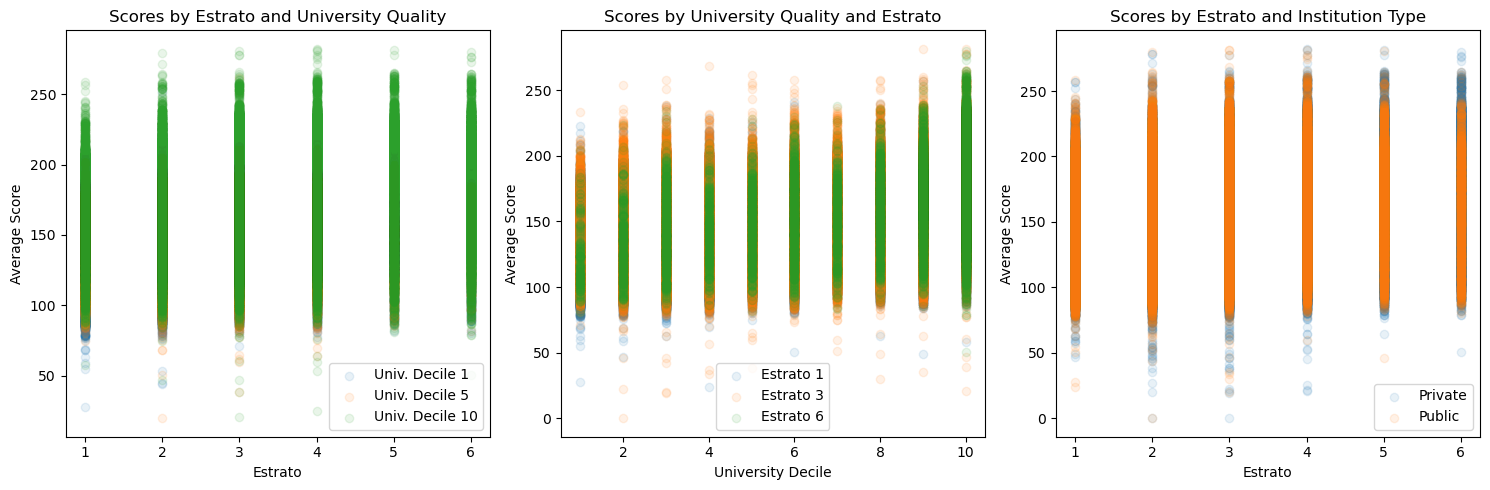


Average Effects:

Scores by Estrato:
           mean   count
estrato                
1        138.40  205859
2        145.70  409772
3        151.88  366009
4        161.68  112567
5        167.16   40673
6        171.98   21708

Scores by University Decile:
                     mean   count
university_decile                
1                  129.69   64213
2                  135.16  176516
3                  139.56  192816
4                  141.84   92839
5                  144.09   71114
6                  147.12   98220
7                  150.59   70327
8                  155.18  107248
9                  161.75  128924
10                 177.92  154371

Scores by Institution Type:
             mean   count
is_public                
0          148.27  772547
1          150.95  384041


In [47]:
# Clean and prepare data for regression
regression_data_clean = regression_data.copy()

# Drop rows with missing values
regression_data_clean = regression_data_clean.dropna(subset=['avg_score'])

# Verify data types
print("Data types before conversion:")
print(regression_data_clean.dtypes)
print("\nMissing values:")
print(regression_data_clean.isnull().sum())

# Basic regression without interactions
X = regression_data_clean[['estrato', 'is_public', 'university_decile', 'department_quartile']].astype(float)
y = regression_data_clean['avg_score'].astype(float)

# Add constant
X = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X).fit()

print("\nBasic Regression Results:")
print(model.summary())

# Create interaction terms
regression_data_clean['public_x_estrato'] = regression_data_clean['is_public'] * regression_data_clean['estrato']
regression_data_clean['university_x_estrato'] = regression_data_clean['university_decile'] * regression_data_clean['estrato']

# Model with interactions
X_interaction = regression_data_clean[['estrato', 'is_public', 'university_decile', 
                                     'department_quartile', 'public_x_estrato', 
                                     'university_x_estrato']].astype(float)
X_interaction = sm.add_constant(X_interaction)
model_interaction = sm.OLS(y, X_interaction).fit()

print("\nRegression Results with Interactions:")
print(model_interaction.summary())

# Visualize relationships
plt.figure(figsize=(15, 5))

# Plot 1: Score vs Estrato by University Decile
plt.subplot(1, 3, 1)
for decile in [1, 5, 10]:
    mask = regression_data_clean['university_decile'] == decile
    data = regression_data_clean[mask]
    plt.scatter(data['estrato'], data['avg_score'], alpha=0.1, 
               label=f'Univ. Decile {decile}')
plt.xlabel('Estrato')
plt.ylabel('Average Score')
plt.title('Scores by Estrato and University Quality')
plt.legend()

# Plot 2: Score vs University Decile by Estrato
plt.subplot(1, 3, 2)
for estrato in [1, 3, 6]:
    mask = regression_data_clean['estrato'] == estrato
    data = regression_data_clean[mask]
    plt.scatter(data['university_decile'], data['avg_score'], alpha=0.1,
               label=f'Estrato {estrato}')
plt.xlabel('University Decile')
plt.ylabel('Average Score')
plt.title('Scores by University Quality and Estrato')
plt.legend()

# Plot 3: Public vs Private by Estrato
plt.subplot(1, 3, 3)
for is_public in [0, 1]:
    mask = regression_data_clean['is_public'] == is_public
    data = regression_data_clean[mask]
    plt.scatter(data['estrato'], data['avg_score'], alpha=0.1,
               label='Public' if is_public else 'Private')
plt.xlabel('Estrato')
plt.ylabel('Average Score')
plt.title('Scores by Estrato and Institution Type')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate average effects
print("\nAverage Effects:")

# By Estrato
estrato_effects = regression_data_clean.groupby('estrato')['avg_score'].agg(['mean', 'count']).round(2)
print("\nScores by Estrato:")
print(estrato_effects)

# By University Decile
univ_effects = regression_data_clean.groupby('university_decile')['avg_score'].agg(['mean', 'count']).round(2)
print("\nScores by University Decile:")
print(univ_effects)

# By Public/Private
public_effects = regression_data_clean.groupby('is_public')['avg_score'].agg(['mean', 'count']).round(2)
print("\nScores by Institution Type:")
print(public_effects)

Full Regression Results:
                            OLS Regression Results                            
Dep. Variable:              avg_score   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                 7.528e+04
Date:                Sat, 01 Feb 2025   Prob (F-statistic):               0.00
Time:                        23:44:23   Log-Likelihood:            -5.2224e+06
No. Observations:             1161252   AIC:                         1.044e+07
Df Residuals:                 1161244   BIC:                         1.044e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const    

/var/folders/sf/chx88sh91jz6pxty2rvf48x40000gn/T/ipykernel_68667/1606774986.py:145: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


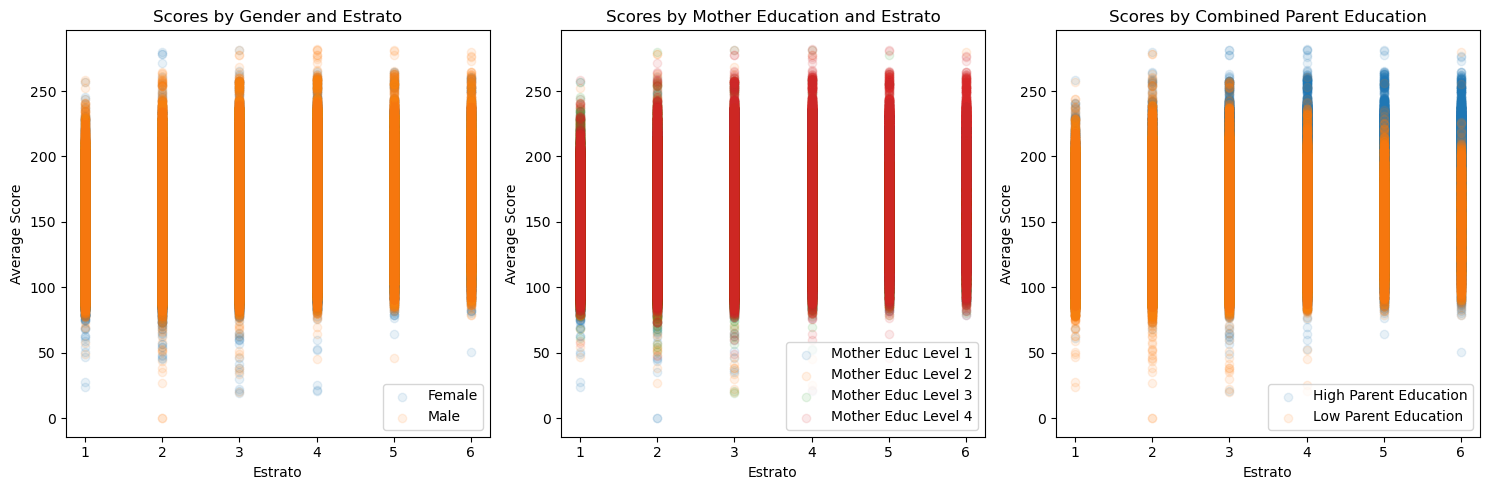


Average Effects by Gender and Parent Education:

Scores by Gender:
           mean   count
is_male                
0        146.36  684985
1        153.39  476267

Scores by Mother's Education Level:
                    mean   count
mother_education                
1.0               138.87  296902
2.0               147.15  385199
3.0               151.69  206920
4.0               161.67  272231

Scores by Father's Education Level:
                    mean   count
father_education                
1.0               141.47  393581
2.0               147.80  346740
3.0               151.51  149671
4.0               161.12  271260


In [49]:
# Updated regression with all variables
regression_data_full = query_db("""
    WITH parent_education AS (
        SELECT 
            estu_consecutivo,
            CASE 
                WHEN fami_educacionpadre IN ('Ninguno', 'No sabe', 'No Aplica', 'Primaria incompleta', 'Primaria completa') 
                    THEN 1  -- Basic or less
                WHEN fami_educacionpadre IN ('Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa')
                    THEN 2  -- Secondary
                WHEN fami_educacionpadre IN ('Técnica o tecnológica incompleta', 'Técnica o tecnológica completa')
                    THEN 3  -- Technical
                WHEN fami_educacionpadre IN ('Educación profesional incompleta', 'Educación profesional completa', 'Postgrado')
                    THEN 4  -- Higher Education
            END as father_education,
            CASE 
                WHEN fami_educacionmadre IN ('Ninguno', 'No sabe', 'No Aplica', 'Primaria incompleta', 'Primaria completa') 
                    THEN 1  -- Basic or less
                WHEN fami_educacionmadre IN ('Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa')
                    THEN 2  -- Secondary
                WHEN fami_educacionmadre IN ('Técnica o tecnológica incompleta', 'Técnica o tecnológica completa')
                    THEN 3  -- Technical
                WHEN fami_educacionmadre IN ('Educación profesional incompleta', 'Educación profesional completa', 'Postgrado')
                    THEN 4  -- Higher Education
            END as mother_education
        FROM saber_pro
    ),
    university_ranks AS (
        SELECT 
            inst_nombre_institucion,
            NTILE(10) OVER (
                ORDER BY AVG((mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
                             mod_ingles_punt + mod_competen_ciudada_punt)/4.0)
            ) as decile
        FROM saber_pro
        GROUP BY inst_nombre_institucion
        HAVING COUNT(*) >= 100
    ),
    department_ranks AS (
        SELECT 
            estu_inst_departamento,
            NTILE(4) OVER (
                ORDER BY AVG((mod_razona_cuantitat_punt + mod_lectura_critica_punt + 
                             mod_ingles_punt + mod_competen_ciudada_punt)/4.0)
            ) as quartile
        FROM saber_pro
        WHERE estu_inst_departamento IS NOT NULL
        GROUP BY estu_inst_departamento
    )
    SELECT 
        s.estu_consecutivo,
        (s.mod_razona_cuantitat_punt + s.mod_lectura_critica_punt + 
         s.mod_ingles_punt + s.mod_competen_ciudada_punt)/4.0 as avg_score,
        CAST(REPLACE(s.fami_estratovivienda, 'Estrato ', '') AS INTEGER) as estrato,
        CASE 
            WHEN s.inst_origen LIKE 'OFICIAL%' OR s.inst_origen = 'REGIMEN ESPECIAL' THEN 1
            WHEN s.inst_origen LIKE 'NO OFICIAL%' THEN 0
        END as is_public,
        CASE 
            WHEN s.estu_genero = 'M' THEN 1
            WHEN s.estu_genero = 'F' THEN 0
        END as is_male,
        ur.decile as university_decile,
        dr.quartile as department_quartile,
        pe.father_education,
        pe.mother_education
    FROM saber_pro s
    LEFT JOIN university_ranks ur ON s.inst_nombre_institucion = ur.inst_nombre_institucion
    LEFT JOIN department_ranks dr ON s.estu_inst_departamento = dr.estu_inst_departamento
    LEFT JOIN parent_education pe ON s.estu_consecutivo = pe.estu_consecutivo
    WHERE s.fami_estratovivienda LIKE 'Estrato %'
        AND s.estu_genero IN ('M', 'F')
""")

# Clean data and run regression
regression_data_full = regression_data_full.dropna()

# Basic model with all variables
X = regression_data_full[['estrato', 'is_public', 'is_male', 'university_decile', 
                         'department_quartile', 'father_education', 'mother_education']].astype(float)
y = regression_data_full['avg_score'].astype(float)
X = sm.add_constant(X)
model_full = sm.OLS(y, X).fit()

print("Full Regression Results:")
print(model_full.summary())

# Model with key interactions
regression_data_full['public_x_estrato'] = regression_data_full['is_public'] * regression_data_full['estrato']
regression_data_full['university_x_estrato'] = regression_data_full['university_decile'] * regression_data_full['estrato']
regression_data_full['male_x_estrato'] = regression_data_full['is_male'] * regression_data_full['estrato']

X_interaction = regression_data_full[['estrato', 'is_public', 'is_male', 'university_decile', 
                                    'department_quartile', 'father_education', 'mother_education',
                                    'public_x_estrato', 'university_x_estrato', 'male_x_estrato']].astype(float)
X_interaction = sm.add_constant(X_interaction)
model_interaction = sm.OLS(y, X_interaction).fit()

print("\nRegression Results with Interactions:")
print(model_interaction.summary())

# Visualize gender differences across estratos
plt.figure(figsize=(15, 5))

# Plot 1: Gender differences by estrato
plt.subplot(1, 3, 1)
for gender in [0, 1]:
    mask = regression_data_full['is_male'] == gender
    data = regression_data_full[mask]
    plt.scatter(data['estrato'], data['avg_score'], alpha=0.1,
               label='Male' if gender else 'Female')
plt.xlabel('Estrato')
plt.ylabel('Average Score')
plt.title('Scores by Gender and Estrato')
plt.legend()

# Plot 2: Parent education effect
plt.subplot(1, 3, 2)
for educ in range(1, 5):
    mask = regression_data_full['mother_education'] == educ
    data = regression_data_full[mask]
    plt.scatter(data['estrato'], data['avg_score'], alpha=0.1,
               label=f'Mother Educ Level {educ}')
plt.xlabel('Estrato')
plt.ylabel('Average Score')
plt.title('Scores by Mother Education and Estrato')
plt.legend()

# Plot 3: Combined effects
plt.subplot(1, 3, 3)
high_educ = (regression_data_full['mother_education'] >= 3) & (regression_data_full['father_education'] >= 3)
low_educ = (regression_data_full['mother_education'] <= 2) & (regression_data_full['father_education'] <= 2)

plt.scatter(regression_data_full[high_educ]['estrato'], 
           regression_data_full[high_educ]['avg_score'], 
           alpha=0.1, label='High Parent Education')
plt.scatter(regression_data_full[low_educ]['estrato'], 
           regression_data_full[low_educ]['avg_score'], 
           alpha=0.1, label='Low Parent Education')
plt.xlabel('Estrato')
plt.ylabel('Average Score')
plt.title('Scores by Combined Parent Education')
plt.legend()

plt.tight_layout()
plt.show()

# Print average effects
print("\nAverage Effects by Gender and Parent Education:")
print("\nScores by Gender:")
print(regression_data_full.groupby('is_male')['avg_score'].agg(['mean', 'count']).round(2))

print("\nScores by Mother's Education Level:")
print(regression_data_full.groupby('mother_education')['avg_score'].agg(['mean', 'count']).round(2))

print("\nScores by Father's Education Level:")
print(regression_data_full.groupby('father_education')['avg_score'].agg(['mean', 'count']).round(2))

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

def query_db(query):
    """Helper function to run SQL queries"""
    conn = sqlite3.connect('data/processed/saber_pro.db')
    result = pd.read_sql_query(query, conn)
    conn.close()
    return result

# First, let's check our data quality
data_check = query_db("""
    SELECT 
        COUNT(*) as total_rows,
        SUM(CASE WHEN mod_razona_cuantitat_punt > 0 AND mod_razona_cuantitat_punt < 300 THEN 1 ELSE 0 END) as valid_scores,
        SUM(CASE WHEN fami_estratovivienda LIKE 'Estrato %' THEN 1 ELSE 0 END) as valid_estrato,
        SUM(CASE WHEN inst_origen IS NOT NULL THEN 1 ELSE 0 END) as valid_institution,
        SUM(CASE WHEN fami_tieneinternet IN ('Si', 'No') THEN 1 ELSE 0 END) as valid_internet,
        SUM(CASE WHEN fami_tienecomputador IN ('Si', 'No') THEN 1 ELSE 0 END) as valid_computer,
        SUM(CASE WHEN estu_pagomatriculapropio IN ('Si', 'No') THEN 1 ELSE 0 END) as valid_self_paid,
        SUM(CASE WHEN estu_pagomatriculapadres IN ('Si', 'No') THEN 1 ELSE 0 END) as valid_parent_paid
    FROM saber_pro;
""")

print("Data quality check:")
print(data_check)

# Modified query with additional data quality checks
regression_data_extended = query_db("""
    WITH clean_scores AS (
        SELECT *
        FROM saber_pro
        WHERE mod_razona_cuantitat_punt > 0 AND mod_razona_cuantitat_punt < 300
        AND mod_lectura_critica_punt > 0 AND mod_lectura_critica_punt < 300
        AND mod_ingles_punt > 0 AND mod_ingles_punt < 300
        AND mod_competen_ciudada_punt > 0 AND mod_competen_ciudada_punt < 300
    ),
    parent_education AS (
        SELECT 
            estu_consecutivo,
            CASE 
                WHEN fami_educacionpadre IN ('Ninguno', 'No sabe', 'No Aplica', 'Primaria incompleta', 'Primaria completa') 
                    THEN 1
                WHEN fami_educacionpadre IN ('Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa')
                    THEN 2
                WHEN fami_educacionpadre IN ('Técnica o tecnológica incompleta', 'Técnica o tecnológica completa')
                    THEN 3
                WHEN fami_educacionpadre IN ('Educación profesional incompleta', 'Educación profesional completa', 'Postgrado')
                    THEN 4
                ELSE NULL
            END as father_education,
            CASE 
                WHEN fami_educacionmadre IN ('Ninguno', 'No sabe', 'No Aplica', 'Primaria incompleta', 'Primaria completa') 
                    THEN 1
                WHEN fami_educacionmadre IN ('Secundaria (Bachillerato) incompleta', 'Secundaria (Bachillerato) completa')
                    THEN 2
                WHEN fami_educacionmadre IN ('Técnica o tecnológica incompleta', 'Técnica o tecnológica completa')
                    THEN 3
                WHEN fami_educacionmadre IN ('Educación profesional incompleta', 'Educación profesional completa', 'Postgrado')
                    THEN 4
                ELSE NULL
            END as mother_education
        FROM clean_scores
    )
    SELECT 
        (s.mod_razona_cuantitat_punt + s.mod_lectura_critica_punt + 
         s.mod_ingles_punt + s.mod_competen_ciudada_punt)/4.0 as avg_score,
        CAST(REPLACE(s.fami_estratovivienda, 'Estrato ', '') AS INTEGER) as estrato,
        CASE 
            WHEN s.inst_origen LIKE 'OFICIAL%' OR s.inst_origen = 'REGIMEN ESPECIAL' THEN 1
            WHEN s.inst_origen LIKE 'NO OFICIAL%' THEN 0
        END as is_public,
        CASE WHEN s.estu_genero = 'M' THEN 1 ELSE 0 END as is_male,
        CASE WHEN s.fami_tieneinternet = 'Si' THEN 1 ELSE 0 END as has_internet,
        CASE WHEN s.fami_tienecomputador = 'Si' THEN 1 ELSE 0 END as has_computer,
        CASE WHEN s.estu_pagomatriculapropio = 'Si' THEN 1 ELSE 0 END as self_paid,
        CASE WHEN s.estu_pagomatriculapadres = 'Si' THEN 1 ELSE 0 END as parent_paid,
        pe.father_education,
        pe.mother_education
    FROM clean_scores s
    LEFT JOIN parent_education pe ON s.estu_consecutivo = pe.estu_consecutivo
    WHERE s.fami_estratovivienda LIKE 'Estrato %'
        AND s.estu_genero IN ('M', 'F')
        AND s.fami_tieneinternet IN ('Si', 'No')
        AND s.fami_tienecomputador IN ('Si', 'No')
        AND s.estu_pagomatriculapropio IN ('Si', 'No')
        AND s.estu_pagomatriculapadres IN ('Si', 'No')
        AND pe.father_education IS NOT NULL
        AND pe.mother_education IS NOT NULL;
""")

# Clean and prepare data for regression
print("\nData shape before cleaning:", regression_data_extended.shape)
print("\nMissing values:")
print(regression_data_extended.isnull().sum())

# Drop any remaining missing values
regression_data_clean = regression_data_extended.dropna()
print("\nData shape after cleaning:", regression_data_clean.shape)

# Basic model
X = regression_data_clean[[
    'estrato', 'is_public', 'is_male', 'father_education', 'mother_education',
    'has_internet', 'has_computer', 'self_paid', 'parent_paid'
]].astype(float)
y = regression_data_clean['avg_score'].astype(float)

# Add constant and fit model
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print("\nRegression Results:")
print(model.summary())

Data quality check:
   total_rows  valid_scores  valid_estrato  valid_institution  valid_internet  \
0     1217482       1215316        1156706            1217482         1169978   

   valid_computer  valid_self_paid  valid_parent_paid  
0         1152569          1205066            1205130  


In [3]:
import sqlite3
import pandas as pd

def query_db(query):
    """Helper function to run SQL queries"""
    conn = sqlite3.connect('data/processed/saber_pro.db')
    result = pd.read_sql_query(query, conn)
    conn.close()
    return result

In [11]:
import sqlite3
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

def query_db(query):
    """Helper function to run SQL queries"""
    conn = sqlite3.connect('data/processed/saber_pro.db')
    result = pd.read_sql_query(query, conn)
    conn.close()
    return result


In [1]:
import statsmodels.api as sm
from src.data_processing import get_regression_data, prepare_regression_variables

# Get clean data
regression_data = get_regression_data()

# Prepare variables
X, y = prepare_regression_variables(regression_data)

# Add constant and fit model
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print("\nRegression Results:")
print(model.summary())

ModuleNotFoundError: No module named 'src'